In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

from pathlib import Path
from warnings import filterwarnings
import ast
filterwarnings('ignore')


In [4]:
df = pd.read_csv(Path(r"/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/1/classes_rgb_values.csv"))

df = df[['semantic_class', 'rgb_values']]

df['rgb_values'] = df['rgb_values'].apply(ast.literal_eval)
rgb_dict = dict(zip(df['semantic_class'], df['rgb_values']))

rgb_dict

{'Traffic Sign': [220, 220, 0],
 'Building': [70, 70, 70],
 'Fence': [190, 153, 153],
 'Other': [250, 170, 160],
 'Pedestrian': [220, 20, 60],
 'Pole': [153, 153, 153],
 'Road Line': [157, 234, 50],
 'Road': [128, 64, 128],
 'Sidewalk': [244, 35, 232],
 'Vegetation': [107, 142, 35],
 'Car': [0, 0, 142],
 'Wall': [102, 102, 156],
 'Unlabeled': [0, 0, 0]}

In [5]:
def color_mask(img: np.ndarray, color: tuple[int, int, int], tol: int) -> np.ndarray:

	color = np.array(color, dtype=np.int16)
	img_int = img.astype(np.int16)

	diff = np.abs(img_int - color)
	mask = np.all(diff <= tol, axis=-1)

	return mask

In [6]:
def color_mask_hsv_resistant(img: np.ndarray, color: tuple[int,int,int], tol_h: int = 10, min_s: int = 30) -> np.ndarray:
	"""
	Odporna na cienie maska koloru w HSV.
	
	Parametry:
		img: HxWx3 RGB uint8
		color: RGB target
		tol_h: tolerancja odcienia H (0-180 OpenCV)
		min_s: minimalne nasycenie pikseli do uwzględnienia (0-255)
		
	Zwraca:
		maska bool HxW
	"""
	hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

	color_bgr = np.uint8([[color[::-1]]])
	color_hsv = cv2.cvtColor(color_bgr, cv2.COLOR_BGR2HSV)[0,0]
	h_target = color_hsv[0]

	h = hsv[...,0]
	s = hsv[...,1]

	dh = np.minimum(np.abs(h - h_target), 180 - np.abs(h - h_target))

	mask = (dh <= tol_h) & (s >= min_s)
	return mask

In [7]:
img = cv2.imread("/home/patryk/Desktop/siapwpa/siapwpa_ros2_project-main/model_trening/test_imgs/image.png")
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Road

(np.float64(-0.5), np.float64(634.5), np.float64(483.5), np.float64(-0.5))

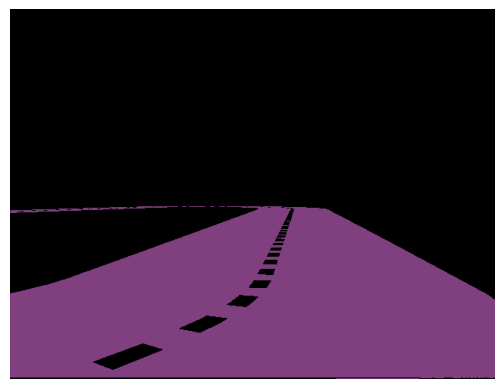

In [8]:
target_color = (31, 42, 55) #Road
tolerance = 15

mask = color_mask(img_rgb, target_color, tolerance)
mask_rgb = np.stack([mask]*3, axis=-1)

plt.imshow(mask_rgb*rgb_dict['Road'])
plt.axis(False)

## Road Line

(np.float64(-0.5), np.float64(634.5), np.float64(483.5), np.float64(-0.5))

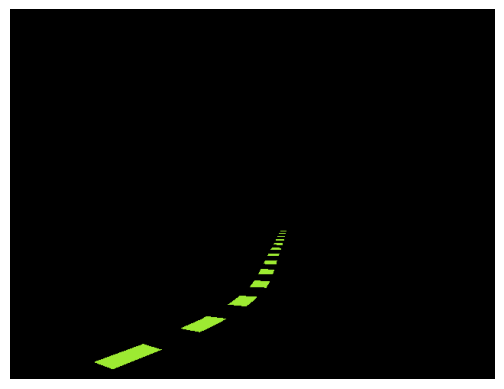

In [9]:
target_color = (175, 104, 0) #Road Line
tolerance = 18

mask = color_mask(img_rgb, target_color, tolerance)
mask_rgb = np.stack([mask]*3, axis=-1)

plt.imshow(mask_rgb*rgb_dict['Road Line'])
plt.axis(False)

## Vegetation

(np.float64(-0.5), np.float64(634.5), np.float64(483.5), np.float64(-0.5))

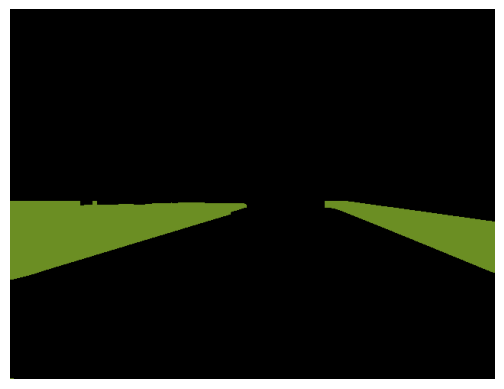

In [ ]:
target_color = (77, 111, 86)

tolerance = 18

mask = cv2.medianBlur(color_mask(img_rgb, target_color, tolerance).astype(np.uint8)*255, ksize=17).astype(bool) 
mask_rgb = np.stack([mask]*3, axis=-1)

plt.imshow(mask_rgb*rgb_dict['Vegetation'])
plt.axis(False)

## Wall

(np.float64(-0.5), np.float64(634.5), np.float64(483.5), np.float64(-0.5))

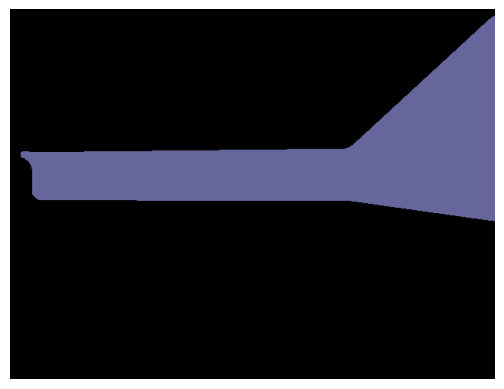

In [11]:
target_color = (41, 65, 77)

tolerance = 15

mask = cv2.medianBlur(color_mask(img_rgb, target_color, tolerance).astype(np.uint8)*255, ksize=17).astype(bool)
mask_rgb = np.stack([mask]*3, axis=-1)

plt.imshow(mask_rgb*rgb_dict['Wall'])
plt.axis(False)

## Sidewalk

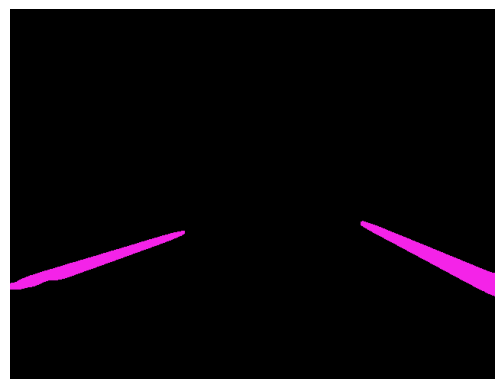

In [12]:
target_color = (161, 161, 156)

tolerance = 10

mask = color_mask(img_rgb, target_color, tolerance)
mask_blur = cv2.medianBlur(mask.astype(np.uint8)*255, ksize=17)
mask_bool = mask_blur.astype(bool)

mask_rgb = np.stack([mask_bool.astype(np.uint8)]*3, axis=-1)

plt.imshow(mask_rgb*rgb_dict['Sidewalk'])
plt.axis("off")
plt.show()

In [19]:
target_colors = ((31, 42, 55), #Road
									(175, 104, 0), #Road Line
									(41, 65, 77), #Wall
                                    (77, 111, 86), # Vegetation
									(161, 161, 156)) #Sidewalk

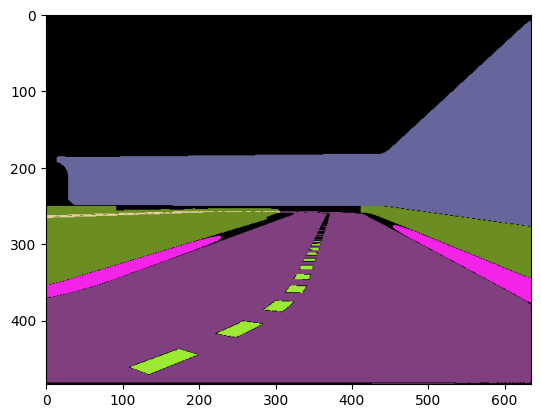

In [22]:
class ROSMaskGenerator():
	def __init__(self, tolerance: int, target_color: tuple, rgb_dict: dict):
		self.tolerance = tolerance
		self.target_color = target_color
		self.rgb_dict = rgb_dict

	def __color_mask(self, img: np.ndarray, color: tuple[int, int, int], tol: int) -> np.ndarray:
		color = np.array(color, dtype=np.int16)
		img_int = img.astype(np.int16)

		diff = np.abs(img_int - color)
		mask = np.all(diff <= tol, axis=-1)

		mask_rgb = np.stack([mask]*3, axis=-1)

		return mask_rgb

	def process(self, img: np.ndarray, mode: str = "BGR") -> np.ndarray:
		if mode == "BGR":
			img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
		road_mask = self.__color_mask(img, self.target_color[0], self.tolerance)
		roadline_mask = self.__color_mask(img, self.target_color[1], self.tolerance)
		wall_mask = cv2.medianBlur(self.__color_mask(img, self.target_color[2], self.tolerance).astype(np.uint8)*255, ksize=17).astype(bool)
		vege_mask = cv2.medianBlur(self.__color_mask(img, self.target_color[3], self.tolerance).astype(np.uint8)*255, ksize=17).astype(bool)
		sidewalk_mask = cv2.medianBlur(self.__color_mask(img, self.target_color[4], self.tolerance).astype(np.uint8)*255, ksize=17).astype(bool)

		road_mask = road_mask.astype(np.uint8) * self.rgb_dict['Road']
		roadline_mask = roadline_mask.astype(np.uint8) * self.rgb_dict['Road Line']
		vege_mask = vege_mask.astype(np.uint8) * self.rgb_dict['Vegetation']
		wall_mask = wall_mask.astype(np.uint8) * self.rgb_dict['Wall']
		sidewalk_mask = sidewalk_mask.astype(np.uint8) * self.rgb_dict['Sidewalk']

		mask = road_mask + roadline_mask + wall_mask + sidewalk_mask + vege_mask
		mask = np.clip(mask, 0, 255).astype(np.uint8)

		return mask
    

MaskRosGen = ROSMaskGenerator(15, target_colors, rgb_dict)

mask = MaskRosGen.process(img)

plt.imshow(mask)

In [15]:
mask.shape

(484, 635, 3)